In [1]:
%load_ext autoreload
%autoreload 2

In [44]:
import numpy as np
import networkx as nx
from scipy.sparse import lil_matrix, csr_matrix, vstack
import copy
import os
import helper
from wl import *
from joblib import Parallel, delayed
from time import time
import matplotlib.pyplot as plt
from glob import glob
import math

## Retrieve graphs from Tobias' concept-graph extraction library

In [3]:
if 0 == 1:
    GRAPH_DIR = 'extract-concept-graphs/code/data/ng20/{}_graphs'

    def get_graphs(directory):
        graphs = {}
        for topic in os.listdir(directory):
            graph_dir = os.path.join(directory, topic)
            if not os.path.isdir(graph_dir): continue
            graph_file = glob(os.path.join(graph_dir, '*.gml'))[0]
            with open(graph_file) as f:
                graph = f.read().split('\n')
            for idx, line in enumerate(graph):
                if line.startswith('label'):
                    next_line = graph[idx + 1]
                    label = next_line.replace('name', 'label')
                    graph[idx] = label
            new_graph_file = graph_file.replace('.gml', '.renamed.gml')
            with open(new_graph_file, 'w') as f:
                f.write('\n'.join(graph))
            graph = nx.read_gml(new_graph_file, label = 'label')
            if graph.number_of_nodes() > 0 and graph.number_of_edges() > 0:
                graphs[topic] = graph
            else:
                graphs[topic] = None
                print("Found empty graph: {}".format(graph_file))
        return graphs
    graphs_test_docs = get_graphs(GRAPH_DIR.format('test'))
    graphs_train_docs = get_graphs(GRAPH_DIR.format('train'))
    assert graphs_test_docs.keys() == graphs_train_docs.keys()
    assert len(graphs_test_docs.keys()) > 0

    all_nodes = [val for sublist in [g.nodes() for g in list(graphs_train_docs.values()) + list(graphs_test_docs.values()) if g is not None] for val in sublist]

In [71]:
DIR = 'data/ng-20-single-document'

def get_graphs(directory, ext = 'gml', undirected = False):
    graphs = {}
    empty_graphs = []
    files = glob(directory + '/*' + ext)
    for idx, graph_file in helper.log_progress(list(enumerate(files)), every = 100):
        topic = graph_file.split('/')[-1].split('_')[0]
        if topic not in graphs:
            graphs[topic] = []
        with open(graph_file) as f:
            graph = f.read().split('\n')
        for idx, line in enumerate(graph):
            if line.startswith('label'):
                next_line = graph[idx + 1]
                label = next_line.replace('name', 'label')
                graph[idx] = label
        try:
            graph = nx.parse_gml(graph)
            if undirected:
                graph = graph.to_undirected()
            #graph = nx.read_gml(new_graph_file, label = 'label')
            if graph.number_of_nodes() > 0 and graph.number_of_edges() > 0:
                graphs[topic].append(graph)
            else:
                empty_graphs.append(graph_file)
                #print("Found empty graph: {}".format(graph_file))
        except nx.NetworkXError as e:
            print(e)
    print('Found empty graphs: {}'.format(len(empty_graphs)))
    return graphs
all_graphs = get_graphs(DIR, undirected = False)

Widget Javascript not detected.  It may not be installed or enabled properly.


node label 'adoni' is duplicated
node label 'mating practices' is duplicated
node label 'hips' is duplicated
node label 'avs' is duplicated
node label 'iges' is duplicated
node label 'hips' is duplicated
node label 'arithmetic coding' is duplicated
node label 'arithmetic coding' is duplicated
node label 'otis' is duplicated
node label 'arithmetic coding' is duplicated
node label 'the wd1002a-wx1' is duplicated
node label 'scsi' is duplicated
node label 'the bios' is duplicated
node label 'cts' is duplicated
node label 'dps' is duplicated
node label 'abs' is duplicated
node label 'lefthanded starters' is duplicated
node label 'tps' is duplicated
node label 'next year' is duplicated
node label 'the flyers' is duplicated
node label 'stu-iiis' is duplicated
node label 'nbs' is duplicated
node label 'pms' is duplicated
node label 'this summer' is duplicated
node label 'this summer' is duplicated
node label 'aids' is duplicated
node label 'bis' is duplicated
node label 'isas' is duplicated
n

In [72]:
REMOVE_CATEGORIES = ('misc.forsale')
graphs = all_graphs.copy()
if len(REMOVE_CATEGORIES):
    del graphs[REMOVE_CATEGORIES]
print(graphs.keys())

dict_keys(['rec.autos', 'talk.religion.misc', 'comp.sys.ibm.pc.hardware', 'comp.windows.x', 'comp.graphics', 'comp.sys.mac.hardware', 'sci.crypt', 'sci.med', 'soc.religion.christian', 'sci.space', 'sci.electronics', 'alt.atheism', 'rec.sport.baseball', 'rec.motorcycles', 'talk.politics.mideast', 'comp.os.ms-windows.misc', 'talk.politics.misc', 'talk.politics.guns', 'rec.sport.hockey'])


In [73]:
import functools

all_nodes = set()
for gs in graphs.values():
    all_nodes |= functools.reduce(lambda acc, x: acc | set(x), [x.nodes() for x in gs], set())
print('Unique tokens found: {}'.format(len(all_nodes)))

Unique tokens found: 123068


## Some helper

In [74]:
def get_wl_for_graphs(graphs, all_nodes = all_nodes,  h = 10, fn = WL_compute):
    nodes = [sorted(g.nodes()) for g in graphs]
    adjs = [nx.adjacency_matrix(g, nodelist = sorted(g.nodes())).toarray() for g in graphs]
    return fn(adjs, nodes, all_nodes = all_nodes, h = h)

In [75]:
graphs_as_list = functools.reduce(lambda acc, x: acc + [(x[0], y) for y in x[1]], graphs.items(), [])
print('Graphs: {}'.format(len(graphs_as_list)))

def get_train_test_split(topic_graphs, train_split_ratio = 0.8):
    train = []
    test = []
    for topic, graphs in topic_graphs.items():
        num_elements_train = int(len(graphs) * train_split_ratio)
        train += [(topic, x) for x in graphs[:num_elements_train]]
        test += [(topic, x) for x in graphs[num_elements_train:]]
    return train, test

train, test = get_train_test_split(graphs)

Graphs: 14060


In [76]:
H = 2

## Calculate gram-matrix for WL kernel for the training concept-graphs

In [77]:
#%%time
from sklearn import svm
import psutil

adjs = []
nodes = []
for topic, graph in train:
    sorted_nodes = sorted(graph.nodes())
    adjs.append(nx.adjacency_matrix(graph, nodelist = sorted_nodes))
    nodes.append(sorted_nodes)

In [78]:
print('Calculating WL_train: start', psutil.virtual_memory())
K_train, phi_list_train, label_lookup_train, label_counters_train = WL_compute(adjs, nodes, H, all_nodes = all_nodes, DEBUG = True, compute_k = False)
print('Calculating WL_train: end', psutil.virtual_memory())

Calculating WL_train: start svmem(total=8589934592, available=3062136832, percent=64.4, used=7703711744, free=280084480, active=3443740672, inactive=2782052352, wired=1477918720)
Number of original labels 123112
K original is computed
Iteration 0: phi is computed
	Graph          0/11240
	Graph       1000/11240
	Graph       2000/11240
	Graph       3000/11240
	Graph       4000/11240
	Graph       5000/11240
	Graph       6000/11240
	Graph       7000/11240
	Graph       8000/11240
	Graph       9000/11240
	Graph      10000/11240
	Graph      11000/11240
Number of compressed labels 124908
Itaration 0: phi computed
Iteration 1: phi is computed
	Graph          0/11240
	Graph       1000/11240
	Graph       2000/11240
	Graph       3000/11240
	Graph       4000/11240
	Graph       5000/11240
	Graph       6000/11240
	Graph       7000/11240
	Graph       8000/11240
	Graph       9000/11240
	Graph      10000/11240
	Graph      11000/11240
Number of compressed labels 125207
Itaration 1: phi computed
Calculati

## Train SVM classifier on the gram-matrix

In [79]:
import sklearn
#clf = svm.SVC(kernel = 'precomputed', verbose = True, probability=True)
clf = sklearn.linear_model.Perceptron(n_iter = 100, verbose = True, n_jobs = -1)

'''
batches = 100
num_elements_per_batch = int(len(train) / 10)
for start in range(batches):
    start = start * num_elements_per_batch
    end = min(len(train), start +
              num_elements_per_batch)
    print('Iteration: {}, #Elements: {}'.format(start, end - start))
    if end - start == 0:
        break
'''
X = phi_list_train[-1].T
Y = [topic for topic, graphs in train]
clf.fit(X, Y)


-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1
-- Epoch 1-- Epoch 1




Norm: 96.84, NNZs: 9345, Bias: -0.010000, T: 11240, Avg. loss: 0.025038

Norm: 95.60, NNZs: 9127, Bias: -0.020000, T: 11240, Avg. loss: 0.021884Norm: 101.38, NNZs: 10226, Bias: -0.010000, T: 11240, Avg. loss: 0.018756Norm: 101.05, NNZs: 10184, Bias: -0.020000, T: 11240, Avg. loss: 0.023497Norm: 108.94, NNZs: 11781, Bias: -0.170000, T: 11240, Avg. loss: 0.042680Norm: 100.09, NNZs: 9984, Bias: -0.020000, T: 11240, Avg. loss: 0.023920
Norm: 95.49, NNZs: 9083, Bias: -0.010000, T: 11240, Avg. loss: 0.019015Norm: 96.77, NNZs: 9340, Bias: -0.010000, T: 11240, Avg. loss: 0.027047




Total training time: 0.03 seconds.

Total training time: 0.03 seconds.Total training time: 0.03 seconds.Total training time: 0.04 seconds.Total training time: 0.03 seconds.Total training time: 0.05 seconds.
Total training time: 0.02 seconds.Total training time: 0.02 seconds.




-- Epoch 2

-- Epoch 2-- Epoch 2-- Epoch 2-- Epoch 

Norm: 100.43, NNZs: 10038, Bias: -0.420000, T: 179840, Avg. loss: 0.001542Norm: 102.43, NNZs: 10440, Bias: -0.490000, T: 179840, Avg. loss: 0.003396

Norm: 108.48, NNZs: 11714, Bias: -0.690000, T: 179840, Avg. loss: 0.001924

Total training time: 0.29 seconds.

Total training time: 0.27 seconds.Total training time: 0.24 seconds.
Total training time: 0.30 seconds.Total training time: 0.33 seconds.
Total training time: 0.30 seconds.Total training time: 0.31 seconds.

Total training time: 0.31 seconds.

-- Epoch 17

-- Epoch 17-- Epoch 17
-- Epoch 17-- Epoch 17
-- Epoch 17-- Epoch 17

-- Epoch 17

Norm: 107.82, NNZs: 11548, Bias: -0.660000, T: 191080, Avg. loss: 0.003212

Norm: 100.69, NNZs: 10118, Bias: -0.470000, T: 191080, Avg. loss: 0.001651Norm: 116.02, NNZs: 13339, Bias: -0.790000, T: 191080, Avg. loss: 0.001556
Norm: 124.32, NNZs: 15146, Bias: -1.000000, T: 191080, Avg. loss: 0.002954Norm: 111.91, NNZs: 12425, Bias: -0.870000, T: 191080, Avg. loss: 0.001925
Norm: 100.43, NNZs: 1003

Norm: 116.02, NNZs: 13339, Bias: -0.790000, T: 393400, Avg. loss: 0.000756
Norm: 124.32, NNZs: 15146, Bias: -1.000000, T: 393400, Avg. loss: 0.001435Norm: 111.91, NNZs: 12425, Bias: -0.870000, T: 393400, Avg. loss: 0.000935
Norm: 100.43, NNZs: 10038, Bias: -0.420000, T: 393400, Avg. loss: 0.000705Norm: 102.48, NNZs: 10451, Bias: -0.490000, T: 393400, Avg. loss: 0.002247Norm: 100.69, NNZs: 10118, Bias: -0.470000, T: 393400, Avg. loss: 0.000802
Norm: 108.48, NNZs: 11714, Bias: -0.690000, T: 393400, Avg. loss: 0.000879

Total training time: 0.64 seconds.


Total training time: 0.57 seconds.
Total training time: 0.64 seconds.Total training time: 0.67 seconds.
Total training time: 0.64 seconds.Total training time: 0.66 seconds.Total training time: 0.67 seconds.
Total training time: 0.64 seconds.

-- Epoch 36


-- Epoch 36
-- Epoch 36-- Epoch 36
-- Epoch 36-- Epoch 36-- Epoch 36
-- Epoch 36

Norm: 107.81, NNZs: 11545, Bias: -0.670000, T: 404640, Avg. loss: 0.002208


Norm: 116.02, NNZs: 1333

Total training time: 0.07 seconds.





-- Epoch 4
-- Epoch 4-- Epoch 4-- Epoch 4-- Epoch 4-- Epoch 4-- Epoch 4
-- Epoch 4





Norm: 113.65, NNZs: 12788, Bias: -0.590000, T: 44960, Avg. loss: 0.010076
Norm: 103.87, NNZs: 10751, Bias: -0.470000, T: 44960, Avg. loss: 0.006691Norm: 156.80, NNZs: 23897, Bias: -1.000000, T: 44960, Avg. loss: 0.018589Norm: 115.76, NNZs: 13203, Bias: -0.660000, T: 44960, Avg. loss: 0.008973Norm: 132.89, NNZs: 17404, Bias: -0.990000, T: 44960, Avg. loss: 0.014597Norm: 130.75, NNZs: 16756, Bias: -0.990000, T: 44960, Avg. loss: 0.017687Norm: 127.66, NNZs: 16165, Bias: -0.820000, T: 44960, Avg. loss: 0.010659
Norm: 128.73, NNZs: 16386, Bias: -0.940000, T: 44960, Avg. loss: 0.013468





Total training time: 0.07 seconds.
Total training time: 0.06 seconds.Total training time: 0.07 seconds.Total training time: 0.08 seconds.Total training time: 0.06 seconds.Total training time: 0.07 seconds.Total training time: 0.07 seconds.
Total training time: 0.08 seconds.







[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    4.3s finished


Perceptron(alpha=0.0001, class_weight=None, eta0=1.0, fit_intercept=True,
      n_iter=100, n_jobs=-1, penalty=None, random_state=0, shuffle=True,
      verbose=True, warm_start=False)

Norm: 127.66, NNZs: 16165, Bias: -0.820000, T: 663160, Avg. loss: 0.000723
Norm: 129.19, NNZs: 16466, Bias: -0.940000, T: 663160, Avg. loss: 0.000954





Total training time: 1.09 seconds.
Total training time: 1.07 seconds.Total training time: 1.00 seconds.Total training time: 1.06 seconds.Total training time: 1.01 seconds.Total training time: 1.01 seconds.Total training time: 0.96 seconds.
Total training time: 1.11 seconds.





-- Epoch 60
-- Epoch 60-- Epoch 60-- Epoch 60-- Epoch 60-- Epoch 60-- Epoch 60
-- Epoch 60





Norm: 113.90, NNZs: 12845, Bias: -0.620000, T: 674400, Avg. loss: 0.000913
Norm: 103.86, NNZs: 10748, Bias: -0.480000, T: 674400, Avg. loss: 0.000737Norm: 156.88, NNZs: 23914, Bias: -1.000000, T: 674400, Avg. loss: 0.001239Norm: 115.84, NNZs: 13217, Bias: -0.650000, T: 674400, Avg. loss: 0.000839Norm: 134.84, NNZs: 17819, Bias: -1.000000, T: 674400, Avg. loss: 0.001194Norm: 131.64, NNZs: 16963, Bias: -1.000000, T: 674400, Avg. loss: 0.001179Norm: 127.66, NNZs: 1616

In [100]:
def get_prediction(topic, graph):
    return compute_phi(graph, phi_list_train[0].shape, label_lookup_train, label_counters_train, h = H)[-1]

USED_SET = test
PARALLEL_PREDICTION_JOBS = 0
t = time()

if PARALLEL_PREDICTION_JOBS > 1:
    phi_test = Parallel(n_jobs=PARALLEL_PREDICTION_JOBS)(delayed(get_prediction)(*d) for d in list(USED_SET))
else:
    phi_test = [get_prediction(*d) for d in USED_SET]
print('Time: {:.2f}s'.format(time() - t, PARALLEL_PREDICTION_JOBS))

Time: 35.08s


In [101]:
import gc
gc.collect()

48502

In [102]:
%%time
def calculate_batches(l, fn, num_batches = 100):
    elements = []
    num_elements_per_batch = math.ceil(len(l) / num_batches)
    print('Starting: #elements: {}, #batches: {}, #elements per Batch: {}'.format(len(l), num_batches, num_elements_per_batch))
    for idx in range(num_batches):
        start = idx * num_elements_per_batch
        end = min(len(l), start + num_elements_per_batch)
        if idx % 10 == 0: print('\tIteration: {:>4}/{}'.format(idx, num_batches))
        if end - start <= 0:
            break
        elements += fn(l[start:end]).tolist()
    return elements
predicted = calculate_batches(phi_test, clf.predict)

Starting: #elements: 2820, #batches: 100, #elements per Batch: 29
	Iteration:    0/100
	Iteration:   10/100
	Iteration:   20/100
	Iteration:   30/100
	Iteration:   40/100
	Iteration:   50/100
	Iteration:   60/100
	Iteration:   70/100
	Iteration:   80/100
	Iteration:   90/100
CPU times: user 5.12 s, sys: 2.96 s, total: 8.09 s
Wall time: 8.17 s


In [107]:
Y_real = [topic for topic,graph in USED_SET]
Y_pred = predicted

sklearn.metrics.accuracy_score(Y_real, Y_pred), sklearn.metrics.f1_score(Y_real, Y_pred, average='macro')

(0.27304964539007093, 0.30239113594210543)

['alt.atheism' 'comp.graphics' 'comp.os.ms-windows.misc'
 'comp.sys.ibm.pc.hardware' 'comp.sys.mac.hardware' 'comp.windows.x'
 'rec.autos' 'rec.motorcycles' 'rec.sport.baseball' 'rec.sport.hockey'
 'sci.crypt' 'sci.electronics' 'sci.med' 'sci.space'
 'soc.religion.christian' 'talk.politics.guns' 'talk.politics.mideast'
 'talk.politics.misc' 'talk.religion.misc']


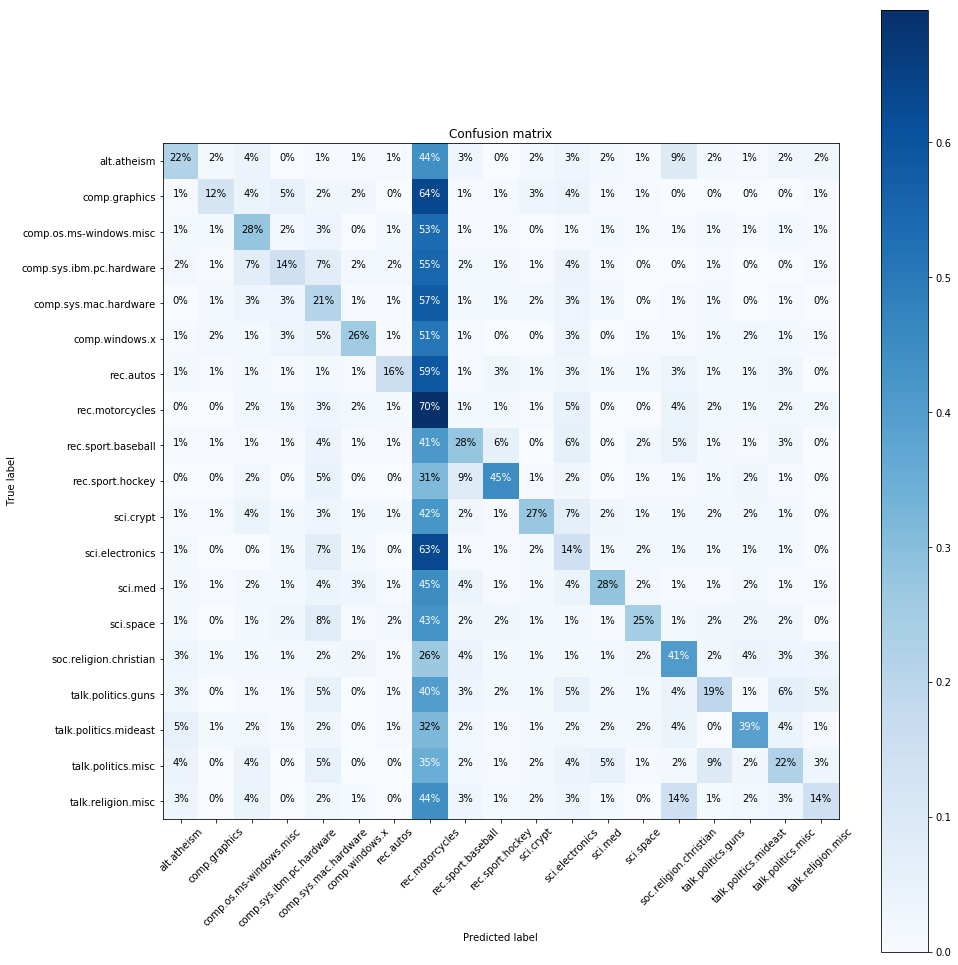

In [108]:
cf_mat = sklearn.metrics.confusion_matrix(Y_real, Y_pred)

fig = plt.figure(figsize=(14, 14))
helper.plot_confusion_matrix(cf_mat, clf.classes_, normalize = True)
plt.show()

In [105]:
import pickle

with open('data/graphs.npy', 'wb') as f:
    pickle.dump({
            'train': train,
            'test': test,
            'K_train': K_train,
            'phi_list_train': phi_list_train,
            'label_lookup_train': label_lookup_train,
            'label_counters_train': label_counters_train
    }, f)

## Test classifier

In [106]:
%store all_graphs_test
%store all_graphs_train
%store K_train
%store phi_list_train
%store label_counters_train
%store label_lookup_train

UsageError: Unknown variable 'all_graphs_test'


## Draw graphs

In [ ]:
if 0 == 1:
    fig = plt.figure(figsize=(30, 30))
    pos=nx.spring_layout(g_mult_dir)
    nx.draw(g_mult_dir, pos = pos)

    edge_labels=dict([((u,v,),d['name'])
                 for u,v,d in g_mult_dir.edges(data=True)])
    nx.draw_networkx_edge_labels(g_mult_dir,pos,edge_labels=edge_labels)
    nx.draw_networkx_nodes(g_mult_dir, pos = pos, label='name', )
    nx.draw_networkx_labels(g_mult_dir, pos = pos)
    plt.show()

    graphs = sorted(list(nx.weakly_connected_component_subgraphs(g_mult_dir)), key = len)#, reverse = True)

    for graph in graphs[-4:]:
        fig = plt.figure(figsize=(20, 20))
        pos=nx.spring_layout(graph)
        #nx.draw(graph, pos = pos)
        edge_labels=dict([((u,v,),d['name'])
                     for u,v,d in graph.edges(data=True)])
        nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels)
        nx.draw_networkx_edges(graph, pos, arrows = True)
        nx.draw_networkx_nodes(graph, pos = pos, label='name')
        nx.draw_networkx_labels(graph, pos = pos)
        plt.show()
